In [1]:
import pandas as pd
import numpy as np
import warnings
import pyodbc
import random
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from collections import Counter
import multiprocessing as mp
import ray
import datetime

warnings.filterwarnings(action = 'ignore')

2023-11-28 08:25:12,011	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.6.3 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


#### 유전 알고리즘 활용한 페어 트레이딩 v6-2

* v2
 - parameter 생성 시 공적분 검정 테스트를 추가하자 (train set 한도내에서)
 - child 생성 시 볼린저밴드 파라미터와 비중 2개로 나누어 crossover
 - mutation 시 볼린저밴드 파라미터 조정과 비중 shuffle

* v3
 - train set/test set 기간을 여러개로 나눠서 각 시뮬레이션 내 종목 비중과 결과 비교
 - 변이 이후 수선 기능을 추가. 각 파라미터의 정상성 테스트 후 p-value 0.05 이하인 것만 고르고 모자라다면 새로 생성
 
* v4
 - v2 + v3, 단 train set 기간 0.7에 대해 먼저 시뮬레이션 해보기
 - Clustering 기법을 도입해서 각 클러스터링 내 가장 score가 좋은 부모 쌍을 고르고 교배. 부모 + 자식 중 best fit을 고르고 변이를 적용해 클러스터링 내 개체 갯수만큼 숫자 채우기
 - Clustering은 KMeans 활용
 
* v5
 - parameter 생성 시 공적분 검정 테스트를 추가하자 (train set 한도내에서)
 - child 생성 시 볼린저밴드 파라미터와 비중 2개로 나누어 crossover
 - mutation 시 볼린저밴드 파라미터 조정과 비중 shuffle
 - 변이 이후 수선 기능을 추가. 각 파라미터의 정상성 테스트 후 p-value 0.05 이하인 것만 고르고 모자라다면 새로 생성
 - train set 기간 0.7에 대해 시뮬레이션 해보기
 - Clustering 활용. 각 개체 내 -비중을 기준으로 clustering. 각 cluster 내에서 child 생성 (이 때 - 숫자는 변하지 않는 식으로 child 생성). 이후 전체 개체 중 best, lucky, 초기생성으로 새로운 세대 추출
 - child 생성 시 elite technique 활용 (부,모,자식 중 가장 스코어 높은 유전체 선택)
 
* v6
 - parameter 생성 시 공적분 검정 테스트를 추가하자 (train set 한도내에서)
 - child 생성 시 볼린저 밴드 계산 기간과 비중 모두 arithmetic crossover 적용. 비중은 적용 후 롱/숏 비중 1로 맞춰주는 작업 추가 
 - mutation 시 볼린저밴드 파라미터 조정과 비중 shuffle
 - 변이 이후 수선 기능을 추가. 각 파라미터의 정상성 테스트 후 p-value 0.05 이하인 것만 고르고 모자라다면 새로 생성
 - train set 기간 0.7에 대해 시뮬레이션 해보기
* v6_2
 - 병렬 프로그래밍으로 같은 시뮬레이션 반복

In [2]:
conn_pcor = pyodbc.connect('driver={Oracle in OraClient18Home1};dbq=PCOR;uid=EF0SEL;pwd=EF0SEL#076')
conn_quant = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=quant;uid=index;pwd=samsung@00')
conn_wisefn = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=wisefn;uid=index;pwd=samsung@00')

In [3]:
os.chdir("..")
os.chdir("..")

os.chdir('00_data')

#df_const = pd.read_json('230927_index_constituent.json')
df_prc_raw = pd.read_json('230927_stk_prc_daily.json')
#df_turnover = pd.read_json('230927_stk_turnover.json')
#df_sector = pd.read_json('230927_stk_sector.json')
#df_mktcap = pd.read_json('230927_stk_mktcap.json')
#df_turnover_daily = pd.read_json('231011_stk_turnover_daily.json')

os.chdir("..")
os.chdir('02_Trading Strategies')
os.chdir('231026_유전 알고리즘을 활용한 페어트레이딩')

In [4]:
sector_code = 'IKS013'

In [5]:
sql_dt = f'''
        SELECT TRD_DT, CLOSE_PRC
        FROM TS_IDX_DAILY
        WHERE 1=1
        AND SEC_CD = '{sector_code}'
        AND TRD_DT > '20091231'
        ORDER BY TRD_DT ASC
'''

df_dt = pd.read_sql(sql_dt, conn_wisefn)

In [6]:
df_dt['TRD_DT'] =  pd.to_datetime(df_dt['TRD_DT'])
df_dt['M'] = df_dt['TRD_DT'].dt.to_period('M')
dt_m = [max(df_dt[df_dt['M']==p]['TRD_DT']) for p in df_dt['M'].unique()]
dt_m = [int(x.strftime('%Y%m%d')) for x in dt_m]

In [7]:
def objective_func(df, params):
    
    #stk_list = sorted(list(set(df['COMP_CD'])))
    
    params_period = params[0]
    params_init = params[1]
    params_exit = params[2]
    params_wt = params[3:]

    df_sp = df * params_wt
    df_sp = df_sp.sum(axis=1)
    
    df_sp_norm = (df_sp - df_sp.rolling(params_period).mean())/df_sp.rolling(params_period).std()
    df_sp_norm.dropna(axis=0, inplace=True)
    
    init_dt = []
    exit_dt = []
    init_yn = 0
    for i in range(len(df_sp_norm)):
        if init_yn == 0:
            if df_sp_norm.iloc[i] < params_init:
                init_dt.append(df_sp_norm.index[i])
                init_yn = 1
        
        elif init_yn == 1:
            if df_sp_norm.iloc[i] > params_exit:
                exit_dt.append(df_sp_norm.index[i])
                init_yn = 0
        
    if len(init_dt) > len(exit_dt):
        if len(init_dt) - len(exit_dt) > 1:
            print("error")
        else:
            init_dt = init_dt[:-1]
    
    ret_list = []
    cum_ret = 1
    for i in range(len(init_dt)):
        dt_1 = init_dt[i]
        dt_2 = exit_dt[i]
        
        prc_1 = df.loc[dt_1]
        prc_2 = df.loc[dt_2]
        
        ret = prc_2/prc_1 - 1
        ret = (ret * params_wt).sum()
        ret_list.append(ret)
        cum_ret *= (1+ret)
    
    return cum_ret

In [8]:
def generate_weight(length):
    
    pos_len = random.randint(1,length - 1)
    neg_len = length - pos_len
    
    pos_wt = []
    for i in range(pos_len):
        p = random.uniform(0,1)
        pos_wt.append(p)
    
    pos_wt = [x/sum(pos_wt) for x in pos_wt]
    
    neg_wt = []
    for i in range(neg_len):
        n = random.uniform(0,1)
        neg_wt.append(n)
    
    neg_wt = [-x/sum(neg_wt) for x in neg_wt]
    
    wt = pos_wt + neg_wt
    
    random.shuffle(wt)
    
    return wt  
        

def generate_params(df, length):
    
    params_period = random.randint(20,20*36)
    params_init = random.uniform(-4,0)
    params_exit = random.uniform(0,4)
    
    while True:
        
        params_wt = generate_weight(length)
        
        df_sp = df * params_wt
        df_sp = df_sp.sum(axis=1)

        result = adfuller(df_sp)
        p_val = result[1]
        
        if p_val < 0.05:        
            params = [params_period, params_init, params_exit, *params_wt]
            
            break

            
    return params
    

In [9]:
def generate_pop(df, size, length):
    population = []
    
    for i in range(size):
        
        params = generate_params(df,length)
        population.append(params)
        
    return population

In [10]:
def compute_performance(df, population):
    
    obj_list = []
    for individual in population:
        obj = objective_func(df, individual)
        obj_list.append([individual,obj])
    
    pop_sorted = sorted(obj_list, key=lambda x: x[1], reverse=True)
    
    return pop_sorted

In [11]:
def select_survivors(population_sorted, best_sample, lucky_few, length, df):
    
    next_gen = []
    
    for i in range(best_sample):
        if population_sorted[i][1] > 0:
            next_gen.append(population_sorted[i][0])
    
    lucky_index = np.random.choice(list(range(len(population_sorted))), lucky_few, replace=False)
    for i in lucky_index:
        next_gen.append(population_sorted[i][0])
    
    next_gen_2 = []
    for item in next_gen:
        if item not in next_gen_2:
            next_gen_2.append(item)
    
    
    while len(next_gen_2) < best_sample + lucky_few:
        next_gen_2.append(generate_params(df, length))
        
    random.shuffle(next_gen_2)
    
    return next_gen_2

In [12]:
def create_child(param1, param2):
    
    a1 = random.random()
    a2 = random.random()
    a3 = random.random()
    a4 = random.random()
    
    child_1 = [int(np.round(a1*param1[0] + (1-a1)*param2[0])), a2*param1[1] + (1-a2)*param2[1], a3*param1[2] + (1-a3)*param2[2],
              *[a4*x + (1-a4)*y for (x,y) in zip(param1[3:],param2[3:])]]
    
    child_2 = [int(np.round((1-a1)*param1[0] + a1*param2[0])), (1-a2)*param1[1] + a2*param2[1], (1-a3)*param1[2] + a3*param2[2],
              *[(1-a4)*x + a4*y for (x,y) in zip(param1[3:],param2[3:])]]
    
    return [child_1, child_2]


def adjust_child(child):
    
    child_wt = child[3:]
    child_pos = [x if x >= 0 else 0 for x in child_wt]
    child_neg = [x if x < 0 else 0 for x in child_wt]
    
    if sum(child_wt) == 0 and sum(child_pos) == 1 and sum(child_neg) == -1:
        adj_child = child
    else:
        child_pos_adj = [x/sum(child_pos) for x in child_pos]
        child_neg_adj = [-x/sum(child_neg) for x in child_neg]
        child_wt_adj = [x+y for (x,y) in zip(child_pos_adj, child_neg_adj)]
        adj_child = child[:3] + child_wt_adj
    
    return adj_child


def create_children(df, population, n_child):
    
    k = 0
    children = []
    
    r_param = 4
    
    fitness = [objective_func(df, x) for x in population]
    roulette = [x - min(fitness) + (max(fitness) - min(fitness))/(r_param - 1) for x in fitness]
    #fitness_2 = [x if x >= 0 else 0 for x in fitness]
    
    prob = [x/sum(roulette) for x in roulette]
    
    while k < n_child:
        try:
            sample = np.random.choice(list(range(len(prob))), 2, replace=False, p = prob)
        except:
            sample = np.random.choice(list(range(len(prob))), 2, replace=False)
        parents = [population[sample[0]], population[sample[1]]]
        
        child_1, child_2 = create_child(parents[0], parents[1])
        children.append(adjust_child(child_1))
        children.append(adjust_child(child_2))
        
        k += 2

    return children

In [13]:
def mutation1(param, prob):
    
    r1 = random.random()
    r2 = random.random()
    r3 = random.random()
    
     
    if r1 < prob:
        param_period = random.randint(20,20*36)
    else:
        param_period = param[0]
           
    if r2 < prob:
        param_init = random.uniform(-4,0)
    else:
        param_init = param[1]
        
    if r3 < prob:
        param_exit = random.uniform(0,4)
    else:
        param_exit = param[2]
        
        
    param_mutate = [param_period, param_init, param_exit, *param[3:]]
    
    return param_mutate


def mutation2(param, prob):
    
    r1 = random.random()
    
    param_wt = param[3:]
    
    if r1 < prob:
        random.shuffle(param_wt)

    param_mutate = param[:3] + param_wt
    
    return param_mutate



################################################
def mutate_pop(population, prob1, prob2):
    
    for i in range(len(population)):
            population[i] = mutation1(population[i], prob1)
            population[i] = mutation2(population[i], prob2)
    
    return population

In [14]:
def mutation_fix(population, df, length):
    
    population_fixed = []
    
    fixed_cnt = 0
    
    for i in population:
        
        params_wt = i[3:]
        
        df_sp = df * params_wt
        df_sp = df_sp.sum(axis=1)
        
        result = adfuller(df_sp)
        p_val = result[1]
        
        if p_val < 0.05:        
            individual_fixed = i
        else:
            new_wt = generate_params(df, length)[3:]
            individual_fixed = i[:3] + new_wt
            fixed_cnt += 1
                
        population_fixed.append(individual_fixed)
        
    return population_fixed, fixed_cnt


In [15]:
def simulation_func(df, params):
    
    #stk_list = sorted(list(set(df['COMP_CD'])))
    
    params_period = params[0]
    params_init = params[1]
    params_exit = params[2]
    params_wt = params[3:]

    df_sp = df * params_wt
    df_sp = df_sp.sum(axis=1)
    
    df_sp_norm = (df_sp - df_sp.rolling(params_period).mean())/df_sp.rolling(params_period).std()
    df_sp_norm.dropna(axis=0, inplace=True)
    
    init_dt = []
    exit_dt = []
    init_yn = 0
    for i in range(len(df_sp_norm)):
        if init_yn == 0:
            if df_sp_norm.iloc[i] < params_init:
                init_dt.append(df_sp_norm.index[i])
                init_yn = 1
        
        elif init_yn == 1:
            if df_sp_norm.iloc[i] > params_exit:
                exit_dt.append(df_sp_norm.index[i])
                init_yn = 0
        
    if len(init_dt) > len(exit_dt):
        if len(init_dt) - len(exit_dt) > 1:
            print("error")
        else:
            init_dt = init_dt[:-1]
    
    ret_list = []
    long_ret_list = []
    short_ret_list = []
    cum_ret = 1
    for i in range(len(init_dt)):
        dt_1 = init_dt[i]
        dt_2 = exit_dt[i]
        
        prc_1 = df.loc[dt_1]
        prc_2 = df.loc[dt_2]

        
        ret = prc_2/prc_1 - 1
        ret_ls = (ret * params_wt).sum()
        ret_list.append(ret_ls)        
        cum_ret *= (1+ret_ls)
        
        long_wt = [x if x >= 0 else 0 for x in params_wt]
        long_ret = (ret * long_wt).sum()
        long_ret_list.append(long_ret)
        
        short_wt = [x if x < 0 else 0 for x in params_wt]
        short_ret = (ret * short_wt).sum()
        short_ret_list.append(short_ret)
        
        
    
    return cum_ret, init_dt, exit_dt, ret_list, long_ret_list, short_ret_list

In [16]:
i = 0.7
base_d = dt_m[int(np.round(len(dt_m)*i,0))]
train_begin_dt = dt_m[0]
train_end_dt = base_d

sql_const = f'''
            SELECT TRD_DT, CONCAT('A',STK_CD) COMP_CD, STK_NM_KOR COMP_NM
            FROM TS_STK_ISSUE
            WHERE 1=1
            AND KS200_TYP = 1
            AND TRD_DT = '{base_d}'
            AND KSC_CD = '{sector_code}'
'''

df_const = pd.read_sql(sql_const, conn_wisefn)

df_train = df_prc_raw.copy()
df_train = df_train[df_train['TRD_DT'] >= train_begin_dt]
df_train = df_train[df_train['TRD_DT'] <= train_end_dt]
df_train = df_train[df_train['COMP_CD'].isin(df_const['COMP_CD'])]
df_train = df_train.sort_values(by = ['TRD_DT','COMP_CD'])
#stk_list = sorted(list(set(df_train['COMP_CD'])))


df_train = df_train.pivot(index = 'TRD_DT', columns = 'COMP_CD')
df_train = df_train.droplevel(axis = 1, level = 0)
#df_train = df_train[stk_list]
df_train.dropna(axis=1, inplace=True)
stk_list = sorted(list(df_train.columns))


df_test = df_prc_raw.copy()
df_test = df_test[df_test['TRD_DT'] >= train_end_dt]
#df_test = df_prc[df_prc['TRD_DT'] <= train_end_dt]
df_test = df_test[df_test['COMP_CD'].isin(df_const['COMP_CD'])]
df_test = df_test.sort_values(by = ['TRD_DT','COMP_CD'])

df_test = df_test.pivot(index = 'TRD_DT', columns = 'COMP_CD')
df_test = df_test.droplevel(axis = 1, level = 0)
df_test = df_test[stk_list]

#### 루프 돌려서 해 안정성 확인하기

In [17]:
mp.cpu_count()

16

In [18]:
ray.init(num_cpus=8)

2023-11-28 08:27:01,384	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.8
Ray version:,2.8.0
Dashboard:,http://127.0.0.1:8265


In [31]:
df_train_ray = ray.put(df_train)
stk_list_ray = ray.put(stk_list)

In [19]:
@ray.remote
def get_optimized_params(df_train, stk_list):
    
    n_generation = 200
    population = 500
    best_sample = int(population/3)
    lucky_few = int(population/3)
    prob1 = 0.01
    prob2 = 0.01
    param_length = len(stk_list)

    pop = generate_pop(df_train, size = population, length = param_length)

    best_gene = []
    best_perf = []

    g = 0

    while True:

        pop_sorted = compute_performance(df_train, pop)

        survivors = select_survivors(pop_sorted, best_sample, lucky_few, param_length, df_train)

        children = create_children(df_train, survivors, population)

        new_generation = mutate_pop(children, prob1, prob2)

        fixed = mutation_fix(new_generation, df_train, param_length)
        fixed_generation = fixed[0]
        fixed_cnt = fixed[1]

        if len(new_generation) < population:
        #    print(f'  세대수 부족: {len(new_generation)}')
            break


        #print(f'  수선 개체 수: {fixed_cnt}')

        pop = fixed_generation
        best_gene.append(pop_sorted[0][0])
        best_perf.append(pop_sorted[0][1])

        temp_sp = df_train * pop_sorted[0][0][3:]
        temp_sp = temp_sp.sum(axis=1)
        result = adfuller(temp_sp)
        p_val = result[1]

        #print(f'====== {g}th generation ends ======')
        #print(pop_sorted[0])
        #print(f'  정상성 체크: p value = {p_val}')

        #gene_count = Counter([tuple(x[0]) for x in pop_sorted])
        #most_common_gene = gene_count.most_common(1)[0][1]
        pop_wt = [x[0][3:] for x in pop_sorted]
        dist_wt = [sum([(x-y)**2 for (x,y) in zip(pop_wt[0],z)]) for z in pop_wt]
        hurdle = 0.05
        dist_wt_hurdle = [1 for x in dist_wt if x < hurdle]

        #print(f'  최다 출현 개체수: {sum(dist_wt_hurdle)}')
        if sum(dist_wt_hurdle) > population * 0.7:
            break

        g += 1

        if g > n_generation:
            break

    print('GA 최적화 완료')
        
    return pop_sorted[0][0], g

In [20]:
futures_2 = [get_optimized_params.remote(df_train, stk_list) for x in range(50)]

In [21]:
futures_2

[ObjectRef(c8ef45ccd0112571ffffffffffffffffffffffff0100000001000000),
 ObjectRef(16310a0f0a45af5cffffffffffffffffffffffff0100000001000000),
 ObjectRef(c2668a65bda616c1ffffffffffffffffffffffff0100000001000000),
 ObjectRef(32d950ec0ccf9d2affffffffffffffffffffffff0100000001000000),
 ObjectRef(e0dc174c83599034ffffffffffffffffffffffff0100000001000000),
 ObjectRef(f4402ec78d3a2607ffffffffffffffffffffffff0100000001000000),
 ObjectRef(f91b78d7db9a6593ffffffffffffffffffffffff0100000001000000),
 ObjectRef(82891771158d68c1ffffffffffffffffffffffff0100000001000000),
 ObjectRef(8849b62d89cb30f9ffffffffffffffffffffffff0100000001000000),
 ObjectRef(80e22aed7718a125ffffffffffffffffffffffff0100000001000000),
 ObjectRef(359ec6ce30d3ca2dffffffffffffffffffffffff0100000001000000),
 ObjectRef(1e8ff6d236132784ffffffffffffffffffffffff0100000001000000),
 ObjectRef(85748392bcd969ccffffffffffffffffffffffff0100000001000000),
 ObjectRef(d695f922effe6d99ffffffffffffffffffffffff0100000001000000),
 ObjectRef(2751d6954

In [22]:
t1 = datetime.datetime.today()

In [23]:
optimized_params = ray.get(futures_2)

(get_optimized_params pid=8968) GA 최적화 완료
(get_optimized_params pid=17996) GA 최적화 완료
(get_optimized_params pid=25000) GA 최적화 완료
(get_optimized_params pid=18280) GA 최적화 완료
(get_optimized_params pid=14288) GA 최적화 완료
(get_optimized_params pid=11820) GA 최적화 완료
(get_optimized_params pid=25172) GA 최적화 완료
(get_optimized_params pid=8936) GA 최적화 완료
(get_optimized_params pid=8968) GA 최적화 완료
(get_optimized_params pid=18280) GA 최적화 완료
(get_optimized_params pid=25000) GA 최적화 완료
(get_optimized_params pid=11820) GA 최적화 완료
(get_optimized_params pid=25172) GA 최적화 완료
(get_optimized_params pid=14288) GA 최적화 완료
(get_optimized_params pid=17996) GA 최적화 완료
(get_optimized_params pid=8936) GA 최적화 완료
(get_optimized_params pid=8968) GA 최적화 완료
(get_optimized_params pid=18280) GA 최적화 완료
(get_optimized_params pid=25172) GA 최적화 완료
(get_optimized_params pid=14288) GA 최적화 완료
(get_optimized_params pid=17996) GA 최적화 완료
(get_optimized_params pid=25000) GA 최적화 완료
(get_optimized_params pid=8936) GA 최적화 완료
(get_optimized_pa

In [24]:
t2 = datetime.datetime.today()

lt_2 = (t2 - t1).seconds

In [25]:
t1, t2

(datetime.datetime(2023, 11, 28, 8, 27, 14, 106261),
 datetime.datetime(2023, 11, 28, 15, 28, 15, 136724))

(get_optimized_params pid=17996) GA 최적화 완료


In [28]:
lt_2/1677

15.063208109719737

In [29]:
optimized_params

[([211,
   -1.785436404472341,
   2.18111177130235,
   0.10362821209624894,
   0.371432944510726,
   -0.10469826311009783,
   -0.0032197627320613756,
   0.07640363357135563,
   -0.07014572214726823,
   0.15800620763252887,
   0.24839885632069386,
   -0.0012654776669446374,
   -0.024419224536062857,
   0.04213014586844671,
   -0.7962515498075651],
  19),
 ([218,
   -1.3127442004180336,
   1.8146480883185019,
   0.012367794969096867,
   0.4812938287792714,
   0.008259433431638328,
   0.02733362272166906,
   0.05367492314398375,
   -0.005438541739187096,
   0.01744251911583296,
   0.048997300975049916,
   0.35063057686345767,
   -0.10280815660346845,
   -0.06845075763701852,
   -0.823302544020326],
  23),
 ([414,
   -1.6489110298831344,
   1.645182147108474,
   -0.13796622401530373,
   0.6180906360626505,
   -0.00508828993605543,
   -0.03673281557585872,
   0.26903329130378656,
   -0.1643312230677586,
   -0.09114945357694337,
   0.043281334792537665,
   0.06959473784102538,
   -0.06653253

In [30]:
ray.shutdown()

In [31]:
optimized_params_1 = [x[0] for x in optimized_params]
optimized_params_2 = [x[1] for x in optimized_params]

In [32]:
df_optimized_params = pd.DataFrame(optimized_params_1)
df_optimized_steps = pd.DataFrame(optimized_params_2)

In [33]:
df_optimized_params

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,211,-1.785436,2.181112,0.103628,0.371433,-0.104698,-0.003220,0.076404,-0.070146,0.158006,0.248399,-0.001265,-0.024419,0.042130,-0.796252
1,218,-1.312744,1.814648,0.012368,0.481294,0.008259,0.027334,0.053675,-0.005439,0.017443,0.048997,0.350631,-0.102808,-0.068451,-0.823303
2,414,-1.648911,1.645182,-0.137966,0.618091,-0.005088,-0.036733,0.269033,-0.164331,-0.091149,0.043281,0.069595,-0.066533,-0.004501,-0.493699
3,245,-0.399989,1.855148,0.004091,0.446877,0.019685,-0.005321,0.057255,0.022536,0.067284,0.084767,0.297506,-0.092889,-0.081058,-0.820732
4,209,-1.190624,1.985186,0.028611,0.230473,0.032282,0.102726,0.042679,-0.004383,0.162688,0.062818,0.337724,-0.012940,-0.045025,-0.937652
5,246,-1.821353,1.971174,0.059388,0.207058,-0.001198,0.034301,-0.010926,-0.056550,0.242034,0.092244,0.316131,0.048844,-0.039840,-0.891486
6,223,-0.911213,1.767587,-0.038605,0.380639,0.094444,0.040919,0.090337,-0.041768,0.030237,0.073451,0.289975,-0.088105,-0.108887,-0.722635
7,217,-1.226547,1.978660,0.007285,0.314366,0.045345,0.035535,0.034566,-0.081733,0.142125,-0.122871,0.420779,-0.031523,-0.037100,-0.726773
8,252,-0.659520,1.453926,-0.120492,0.511605,-0.035548,-0.008688,0.172393,-0.110370,-0.046134,0.117982,0.193740,-0.073973,0.004280,-0.604795
9,249,-1.577772,1.806469,0.009757,0.438445,0.040758,-0.018761,0.022567,-0.003647,0.166149,0.085534,0.236789,-0.045794,-0.190796,-0.741001


In [57]:
df_optimized_params.mean()[3:]

3    -0.017430
4     0.406588
5    -0.001621
6     0.026971
7     0.086625
8    -0.078672
9     0.050728
10    0.059362
11    0.185833
12   -0.055297
13   -0.064186
14   -0.598899
dtype: float64

In [54]:
df_optimized_params.to_json('231128_optimized_params_50 times.json')
df_optimized_steps.to_json('231128_optimization_steps_50 times.json')

In [35]:
params_period = [x[0] for x in optimized_params_1]
params_init = [x[1] for x in optimized_params_1]
params_exit = [x[2] for x in optimized_params_1]
params_wt = [x[3:] for x in optimized_params_1]

(array([ 2.,  9., 20.,  9.,  2.,  1.,  1.,  0.,  2.,  4.]),
 array([165. , 191.4, 217.8, 244.2, 270.6, 297. , 323.4, 349.8, 376.2,
        402.6, 429. ]),
 <BarContainer object of 10 artists>)

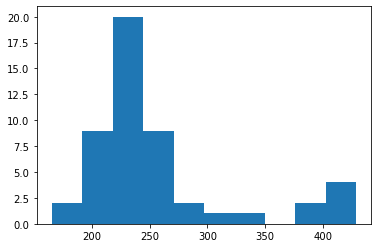

In [36]:
plt.hist(params_period)

In [72]:
np.std(params_period)

62.77618975375935

(array([ 4.,  1.,  5., 13., 17.,  2.,  4.,  2.,  1.,  1.]),
 array([-2.22800543, -2.01829609, -1.80858675, -1.5988774 , -1.38916806,
        -1.17945872, -0.96974938, -0.76004004, -0.55033069, -0.34062135,
        -0.13091201]),
 <BarContainer object of 10 artists>)

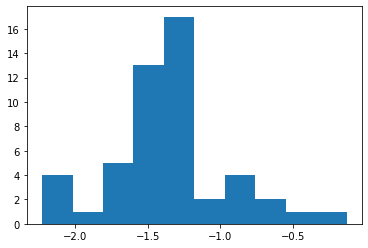

In [37]:
plt.hist(params_init)

(array([ 1.,  4., 10.,  9., 14.,  6.,  4.,  1.,  0.,  1.]),
 array([1.32094186, 1.43044596, 1.53995007, 1.64945417, 1.75895827,
        1.86846238, 1.97796648, 2.08747059, 2.19697469, 2.3064788 ,
        2.4159829 ]),
 <BarContainer object of 10 artists>)

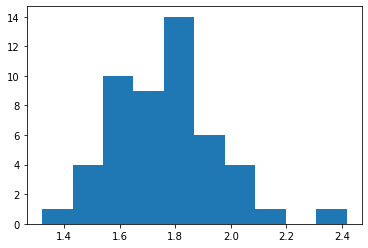

In [38]:
plt.hist(params_exit)

{'whiskers': [<matplotlib.lines.Line2D at 0x20a89c80fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x20a89c986d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20a89c80c70>,
 'medians': [<matplotlib.lines.Line2D at 0x20a89c98d90>,
 'fliers': [<matplotlib.lines.Line2D at 0x20a89ca1130>,
 'means': []}

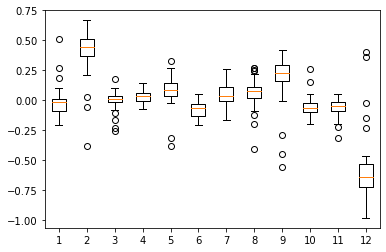

In [43]:
plt.boxplot(pd.DataFrame(params_wt))

In [45]:
result_train = [simulation_func(df_train, x[0]) for x in optimized_params]
result_test = [simulation_func(df_test, x[0]) for x in optimized_params]

In [51]:
result_train[2][3]

[0.2930643434420327,
 2.003551833273335,
 0.4676899426674977,
 0.44211603304577085]

In [53]:
result_summary = pd.DataFrame([params_period, params_init, params_exit, [len(x[1]) for x in result_train],
              [len(x[1]) for x in result_test],[sum([1 for y in x[3] if y > 0]) for x in result_train],
              [sum([1 for y in x[3] if y > 0]) for x in result_test],
              [x[0] for x in result_train],[x[0] for x in result_test]], 
             index = ['period','init','exit','train_cnt','test_cnt','train_hr','test_hr','train_ret','test_ret']).T

result_summary.sort_values('period')

,period,init,exit,train_cnt,test_cnt,train_hr,test_hr,train_ret,test_ret
24,165.0,-1.188044,1.840948,8.0,2.0,8.0,2.0,6.083026,1.655190
34,187.0,-1.648194,1.931553,9.0,0.0,9.0,0.0,8.449128,1.000000
26,193.0,-2.053152,2.415983,7.0,1.0,7.0,1.0,10.691665,1.133085
44,197.0,-1.215942,1.626132,8.0,1.0,8.0,1.0,8.141689,1.055182
15,203.0,-1.141857,1.908960,8.0,1.0,8.0,1.0,10.459209,1.033078
4,209.0,-1.190624,1.985186,8.0,1.0,8.0,1.0,5.837776,1.091350
0,211.0,-1.785436,2.181112,5.0,1.0,5.0,1.0,5.018630,1.146485
20,212.0,-1.443939,1.803469,9.0,1.0,9.0,1.0,9.993953,1.149578
17,215.0,-1.225013,1.829308,8.0,1.0,8.0,1.0,5.882327,1.127433
18,216.0,-1.438226,1.808188,7.0,1.0,7.0,1.0,7.393181,1.096875


In [63]:
params_avg = df_optimized_params.mean().to_list()
params_avg[0] = int(np.round(params_avg[0],0))
params_avg

[254,
 -1.3383207296574569,
 1.7600496765350986,
 -0.01743040717084441,
 0.40658780539546874,
 -0.001621292695198638,
 0.02697069155813476,
 0.08662463379218444,
 -0.07867227870162996,
 0.050727761517018584,
 0.059362174764441604,
 0.18583301468730473,
 -0.055296958219449695,
 -0.06418644778610381,
 -0.5988986971413264]

In [67]:
result_train_avg = simulation_func(df_train, params_avg)
result_test_avg = simulation_func(df_test, params_avg)

In [68]:
result_train_avg

(2.918759720827444,
 [20110511, 20130226, 20140806, 20160111, 20170602, 20171019],
 [20110805, 20131002, 20150320, 20170227, 20170622, 20180706],
 [0.0806577224558149,
  0.10546099823954243,
  0.36858380707809657,
  0.1865960947066636,
  0.10820135309488313,
  0.35760606732461814],
 [-0.20432684712957883,
  0.03355153549112144,
  0.2561249613972041,
  0.24299332595146939,
  0.08524135499176219,
  0.1703965076135225],
 [0.28498456958539375,
  0.07190946274842099,
  0.11245884568089237,
  -0.05639723124480578,
  0.02295999810312095,
  0.18720955971109565])

In [69]:
result_test_avg

(1.1030548033022016,
 [20210406],
 [20210805],
 [0.10305480330220171],
 [0.10175678428959561],
 [0.0012980190126060777])